In [92]:
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
from astropy.io import fits
import pandas as pd
import pickle
import cv2
import matplotlib.image as mpimg


## Code taken from my research that reads in and format the files from the dataset

In [93]:
# Read in the table containing the quasar files
quasars = Table.read('GO-12289 target table - all.csv', format='ascii')
print('columns contained in each file:', quasars.columns)


columns contained in each file: <TableColumns names=('name','RA_deg','Dec_deg','redshift','source','SDSS_filename','comment','COS_filename1','COS_filename2')>


In [94]:
# Function created by Professor Sean Johnson that reads in the COS spectrum and returns a version rebinned to a 1 Angstrom pixel.
def readCOS(filename):

    # Read in the COS spectrum
    spec_direct = Table.read('GO-12289_spectra2/{}'.format(filename))

    # Reformat as an astropy Table for convenience
    spec = Table()
    wave = spec_direct['WAVELENGTH']
    spec['wave'] = np.array(spec_direct['WAVELENGTH'])[0, :]
    spec['flux'] = np.array(spec_direct['FLUX'])[0, :]
    spec['error'] = np.array(spec_direct['ERROR'])[0, :]
    spec['nPix'] = np.zeros(len(spec))
    spec = spec[(spec['wave'] > 1100) & (spec['wave'] < 1900)]
    
  
    # Now rebin the spectra to 1 Angstrom intervals: combining 
    dwave = 1
    minwave = np.min(spec['wave'])
    maxwave = np.max(spec['wave'])

    # Create the wavelength array for the rebinned spectrum
    waveArray = np.arange(minwave, maxwave, dwave)
    spec_rebinned = Table()
    spec_rebinned['wave'] = waveArray
    # Fillin dummy values for flux, error, and number of pixels for now.
    spec_rebinned['flux'] = np.zeros(len(waveArray))
    spec_rebinned['error'] = np.zeros(len(waveArray))
    spec_rebinned['nPix'] = np.zeros(len(waveArray))

    # Look through the rebinned spectrum and find the flux, error, and nPix at each wavelength
    for pixel in spec_rebinned:

        # Identify pixels in the original spectrum that should contribute to this pixel in the rebinned spectrum
        index = np.where((spec['wave'] >= pixel['wave'] - dwave/2) & (spec['wave'] < pixel['wave'] + dwave/2))

        # Calculate the mean flux
        pixel['flux'] = np.nanmean(spec[index]['flux'])

        # Calculate the standard deviation which we can use for the error
        pixel['error'] = np.nanstd(spec[index]['error'])

        # Just in case we need it, calculate the number of original pixels contributing to this pixel.
        pixel['nPix'] = len(index[0])

    # Throw out data between 1150 and 1310 Angstroms because it is impacted by Geocoronal emission.
    spec_rebinned = spec_rebinned[(spec_rebinned['wave'] < 1150) | (spec_rebinned['wave'] > 1320)]
    return spec_rebinned


print(readCOS('hst_12289_cos_j101548d27p404008d7_cg140l_lbhx_cspec.fits'))

       wave                 flux                  error          nPix
------------------ ---------------------- ---------------------- ----
1100.0030517578125 2.8452565146606587e-15  6.077138994634056e-16  7.0
1101.0030517578125  2.763206338884266e-15  5.582706275684816e-16 12.0
1102.0030517578125  8.043036290762283e-16  3.669654306344601e-16 13.0
1103.0030517578125  9.028563360057398e-16  3.871245500813164e-16 12.0
1104.0030517578125 1.7411477973652573e-15 4.3747094438647074e-16 12.0
1105.0030517578125  8.496333913419302e-16 3.1529644732172736e-16 13.0
1106.0030517578125 2.3116856854714677e-15  3.795867244743616e-16 12.0
1107.0030517578125 1.5880536860499758e-15  4.939290519829793e-16 13.0
1108.0030517578125 1.7746741025714114e-15  4.017127073643016e-16 12.0
1109.0030517578125  1.891060770568007e-15 3.9240572109810817e-16 12.0
               ...                    ...                    ...  ...
1890.0030517578125 2.3782105943576364e-15  5.954544739804389e-16 13.0
1891.0030517578125  

In [95]:
# Function that calculates the average flux around each pixel and the associated sigma error
# Also removes any indices that have nans or infinite values
def continuum_flux(z, spectrum):
    
    sigma_values = []
    indices = []
    fluxD = []
   
    for i in range(len(spectrum)):
        pixel = spectrum[i]
       
        # For lower bound
        minWave_low = pixel['wave'] - 100
        if minWave_low <= 1150:
            continue
        maxWave_low = pixel['wave']

        spectrum_continuum_low = spectrum[(minWave_low < spectrum['wave']) & (spectrum['wave'] < maxWave_low)]
       
        # Ensure the low continuum is non-empty
        if len(spectrum_continuum_low) == 0:
            continue
            
        # calculate continuum and error for lower bound of flux
        continuum_low = np.nanmean(spectrum_continuum_low['flux'])
        error_low = np.nanstd(spectrum_continuum_low['flux']) / np.sqrt(len(spectrum_continuum_low))
       
        # For high continuum
        minWave_high = pixel['wave']
        maxWave_high = pixel['wave'] + 100

        spectrum_continuum_high = spectrum[(minWave_high < spectrum['wave']) & (spectrum['wave'] < maxWave_high)]

        # Ensure the high continuum is non-empty
        if len(spectrum_continuum_high) == 0:
            continue
            
        # calculate continuum and error for upper bound of flux
        continuum_high = np.nanmean(spectrum_continuum_high['flux'])
        error_high = np.nanstd(spectrum_continuum_high['flux']) / np.sqrt(len(spectrum_continuum_high))

        # Calculate sigma using the mean values
        sigma = np.abs(continuum_high - continuum_low) / np.sqrt((error_low)**2 + (error_high)**2)

        # calculate the difference in flux continua
        flux_drop = (continuum_high - continuum_low) / continuum_high
       
        # Check if sigma is finite and append to the list
        if np.isfinite(sigma):
            sigma_values.append(sigma)
            indices.append(i)
            fluxD.append(flux_drop)

    
    fluxD = np.array(fluxD)
    
    # Convert sigma values list to numpy array
    sigma_values = np.array(sigma_values)
   
    # Filter out NaN and infinite values from sigma_values
    sigma_good = np.isfinite(sigma_values)
   
    # Use indices to filter spectrum['wave']
    wave_good = spectrum['wave'][indices]


    for j in range(len(wave_good)):
        if wave_good[j] > 1840:
            sigma_values[j] = 0
            fluxD[j] = 0
           
    return sigma_values[sigma_good], wave_good, fluxD[sigma_good]




In [96]:
# assigning the calculated sigma, wave, and flux values from the cell above to a table
quasars['ll system'] = 0.0
quasars['sigma'] = 0.0
quasars['flux drop'] = 0.0

for i in range(len(quasars)):
    quasar = quasars[i]
    spec = readCOS(quasar['COS_filename1'])
    redshift = quasar['redshift']
    sigma_good, wave_good, flux_drop = continuum_flux(redshift, spec)
    
    graph_file = Table()
    graph_file['sigma'] = sigma_good
    graph_file['wave'] = wave_good
    graph_file['flux'] = flux_drop
    graph_file.write(quasar['COS_filename1'].replace('.fits', 'trigraph.fits'), overwrite = True)

In [97]:
# putting restrivive bounds/criteria on the sigma value and flux difference
# if the values exceed the bounds, assign the associated quasar with having a lyman jump

quasars['waveMax'] = 0.0

for i in range(len(quasars)):
    quasar = quasars[i]
    t = Table.read(quasar['COS_filename1'].replace('.fits', 'trigraph.fits'))
    ll_found = np.where((t['sigma'] > 5) & (t['flux'] > 1/np.exp(1)))[0]
    if len(ll_found) > 0:
        index = np.argmax(t['sigma'][ll_found])
        waveMax = t['wave'][ll_found[index]]
        quasar['ll system'] = 1
        quasar['waveMax'] = waveMax
    else:
        quasar['ll system'] = 0

    quasar['sigma'] = t['sigma'][i]
    quasar['flux drop'] = t['flux'][i]


In [98]:
# calculating the left and right flux continuum of each quasar spectrum

quasars['left jump'] = 0.0
quasars['right jump'] = 0.0

for i in range(len(quasars)):
    quasar = quasars[i]
    spec = readCOS(quasar['COS_filename1'])
    #print(spec['wave'][i]-25)
    #print(spec['wave'])
    
    spec_left = spec[(spec['wave'] >= spec['wave'][50]) & (spec['wave'] <= spec['wave'][50]+200)]
    spec_left_median = np.median(spec_left['flux'])
    quasars['left jump'][i] = spec_left_median
                
    spec_right = spec[(spec['wave'] >= spec['wave'][628]-200) & (spec['wave'] <= spec['wave'][628])]
    spec_right_median = np.median(spec_right['flux'])
    quasars['right jump'][i] = spec_right_median

    #spec_middle = spec[(spec['wave'] >= spec['wave'][50]+100) & (spec['wave'] <= spec['wave'][628]-125)]
    #spec_middle_median = np.mean(spec_middle['flux'])
    #quasars['central flux'][i] = spec_middle_median




"\nplt.savefig('testing.png')\nplt.show()\n\n\nimage = mpimg.imread('testing.png')\nplt.imshow(image)\nplt.axis('off')  # Optional: Turn off axis labels and ticks\n"

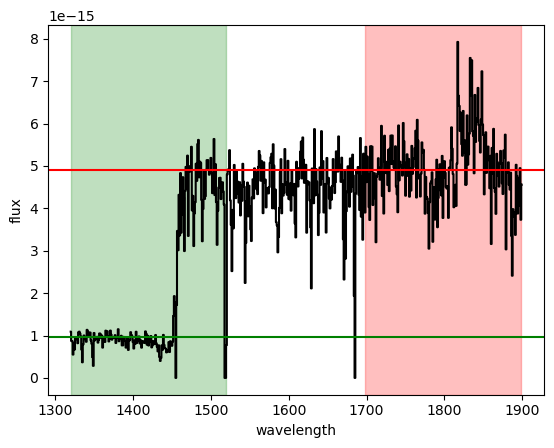

In [99]:
# example spectrum showing what portion of the flux is being used to calculate the continua

quasar1 = quasars[1]
spec1 = readCOS(quasar1['COS_filename1'])
plt.plot(spec1['wave'][50:], spec1['flux'][50:], drawstyle='steps-mid', color='black')
plt.axhline(quasar1['left jump'], color = 'green')
plt.axhline(quasar1['right jump'], color = 'red')
plt.axvspan(spec1['wave'][50], spec1['wave'][50]+200, color='green', alpha=0.25)
plt.axvspan(spec1['wave'][628]-200, spec1['wave'][628], color='red', alpha=0.25)
plt.xlabel('wavelength')
plt.ylabel('flux')

'''
plt.savefig('testing.png')
plt.show()


image = mpimg.imread('testing.png')
plt.imshow(image)
plt.axis('off')  # Optional: Turn off axis labels and ticks
'''

## Initial Test

In [100]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn import neighbors
from sklearn import metrics
import sklearn.preprocessing
from sklearn import model_selection

In [101]:
# creating the dataset that will be used for the model
# only assigning the columns from the quasars table that will be used as features or targets

data = Table()
data['left flux'] = np.zeros(len(quasars))
data['right flux'] = np.zeros(len(quasars))
data['redshift'] = np.zeros(len(quasars))
data['sigma'] = np.zeros(len(quasars))
data['flux drop'] = np.zeros(len(quasars))
data['ll system'] = np.zeros(len(quasars))

for i in range(len(quasars)):
    data_index = data[i]
    data_index['left flux'] = quasars['left jump'][i]
    data_index['right flux'] = quasars['right jump'][i]
    data_index['redshift'] = quasars['redshift'][i]
    data_index['sigma'] = quasars['sigma'][i]
    data_index['flux drop'] = quasars['flux drop'][i]
    data_index['ll system'] = quasars['ll system'][i]

data = data.to_pandas()
print(data.iloc[:35,:])

       left flux    right flux  redshift      sigma  flux drop  ll system
0   1.555395e-15  1.591415e-15   0.92151  10.155735  -0.156672        0.0
1   9.697293e-16  4.913845e-15   0.77951   1.030963  -0.089144        1.0
2   5.529020e-17  2.360858e-15   0.93577   1.404799  -0.226629        1.0
3   3.178591e-15  2.875143e-15   1.00857   0.740281   0.040830        0.0
4   3.939702e-15  3.484733e-15   0.79432   3.946224   0.114670        0.0
5   4.539506e-15  3.943044e-15   1.03570   0.077369   0.002338        0.0
6   2.033864e-16  9.872668e-16   0.96632   1.267205  -0.136374        1.0
7   1.889982e-15  2.970853e-15   0.75550   0.297823  -0.012590        1.0
8   1.776129e-17  2.187264e-15   1.20674   0.970782  -0.314265        1.0
9   3.493275e-15  3.432967e-15   0.92788   2.979552  -0.085424        0.0
10  1.145762e-14  1.089520e-14   0.76662   0.382556   0.009354        0.0
11  1.586903e-15  2.260175e-15   0.85100   5.058474   0.199850        1.0
12  7.190339e-16  1.155223e-15   0.801

In [102]:
# assinging the first 35 in the dataset to the training set and the remaining 19 to the testing set
# splitting the training and testing inputs to be the X features or Y targets

training_set =  data.iloc[:35,:]
testing_set = data.iloc[36:,:]

xtrain = training_set.drop(['ll system'], axis=1)
ytrain = training_set.drop(['left flux', 'right flux', 'redshift', 'sigma', 'flux drop'], axis=1)

xtest = testing_set.drop(['ll system'], axis=1)
ytest = testing_set.drop(['left flux', 'right flux', 'redshift', 'sigma', 'flux drop'], axis=1)

print(len(training_set))
print(len(testing_set))

35
19


In [103]:
# creating the decision tree model and training it on the training set

model = DecisionTreeClassifier(random_state = 3)
model.fit(xtrain, ytrain)

DecisionTreeClassifier(random_state=3)

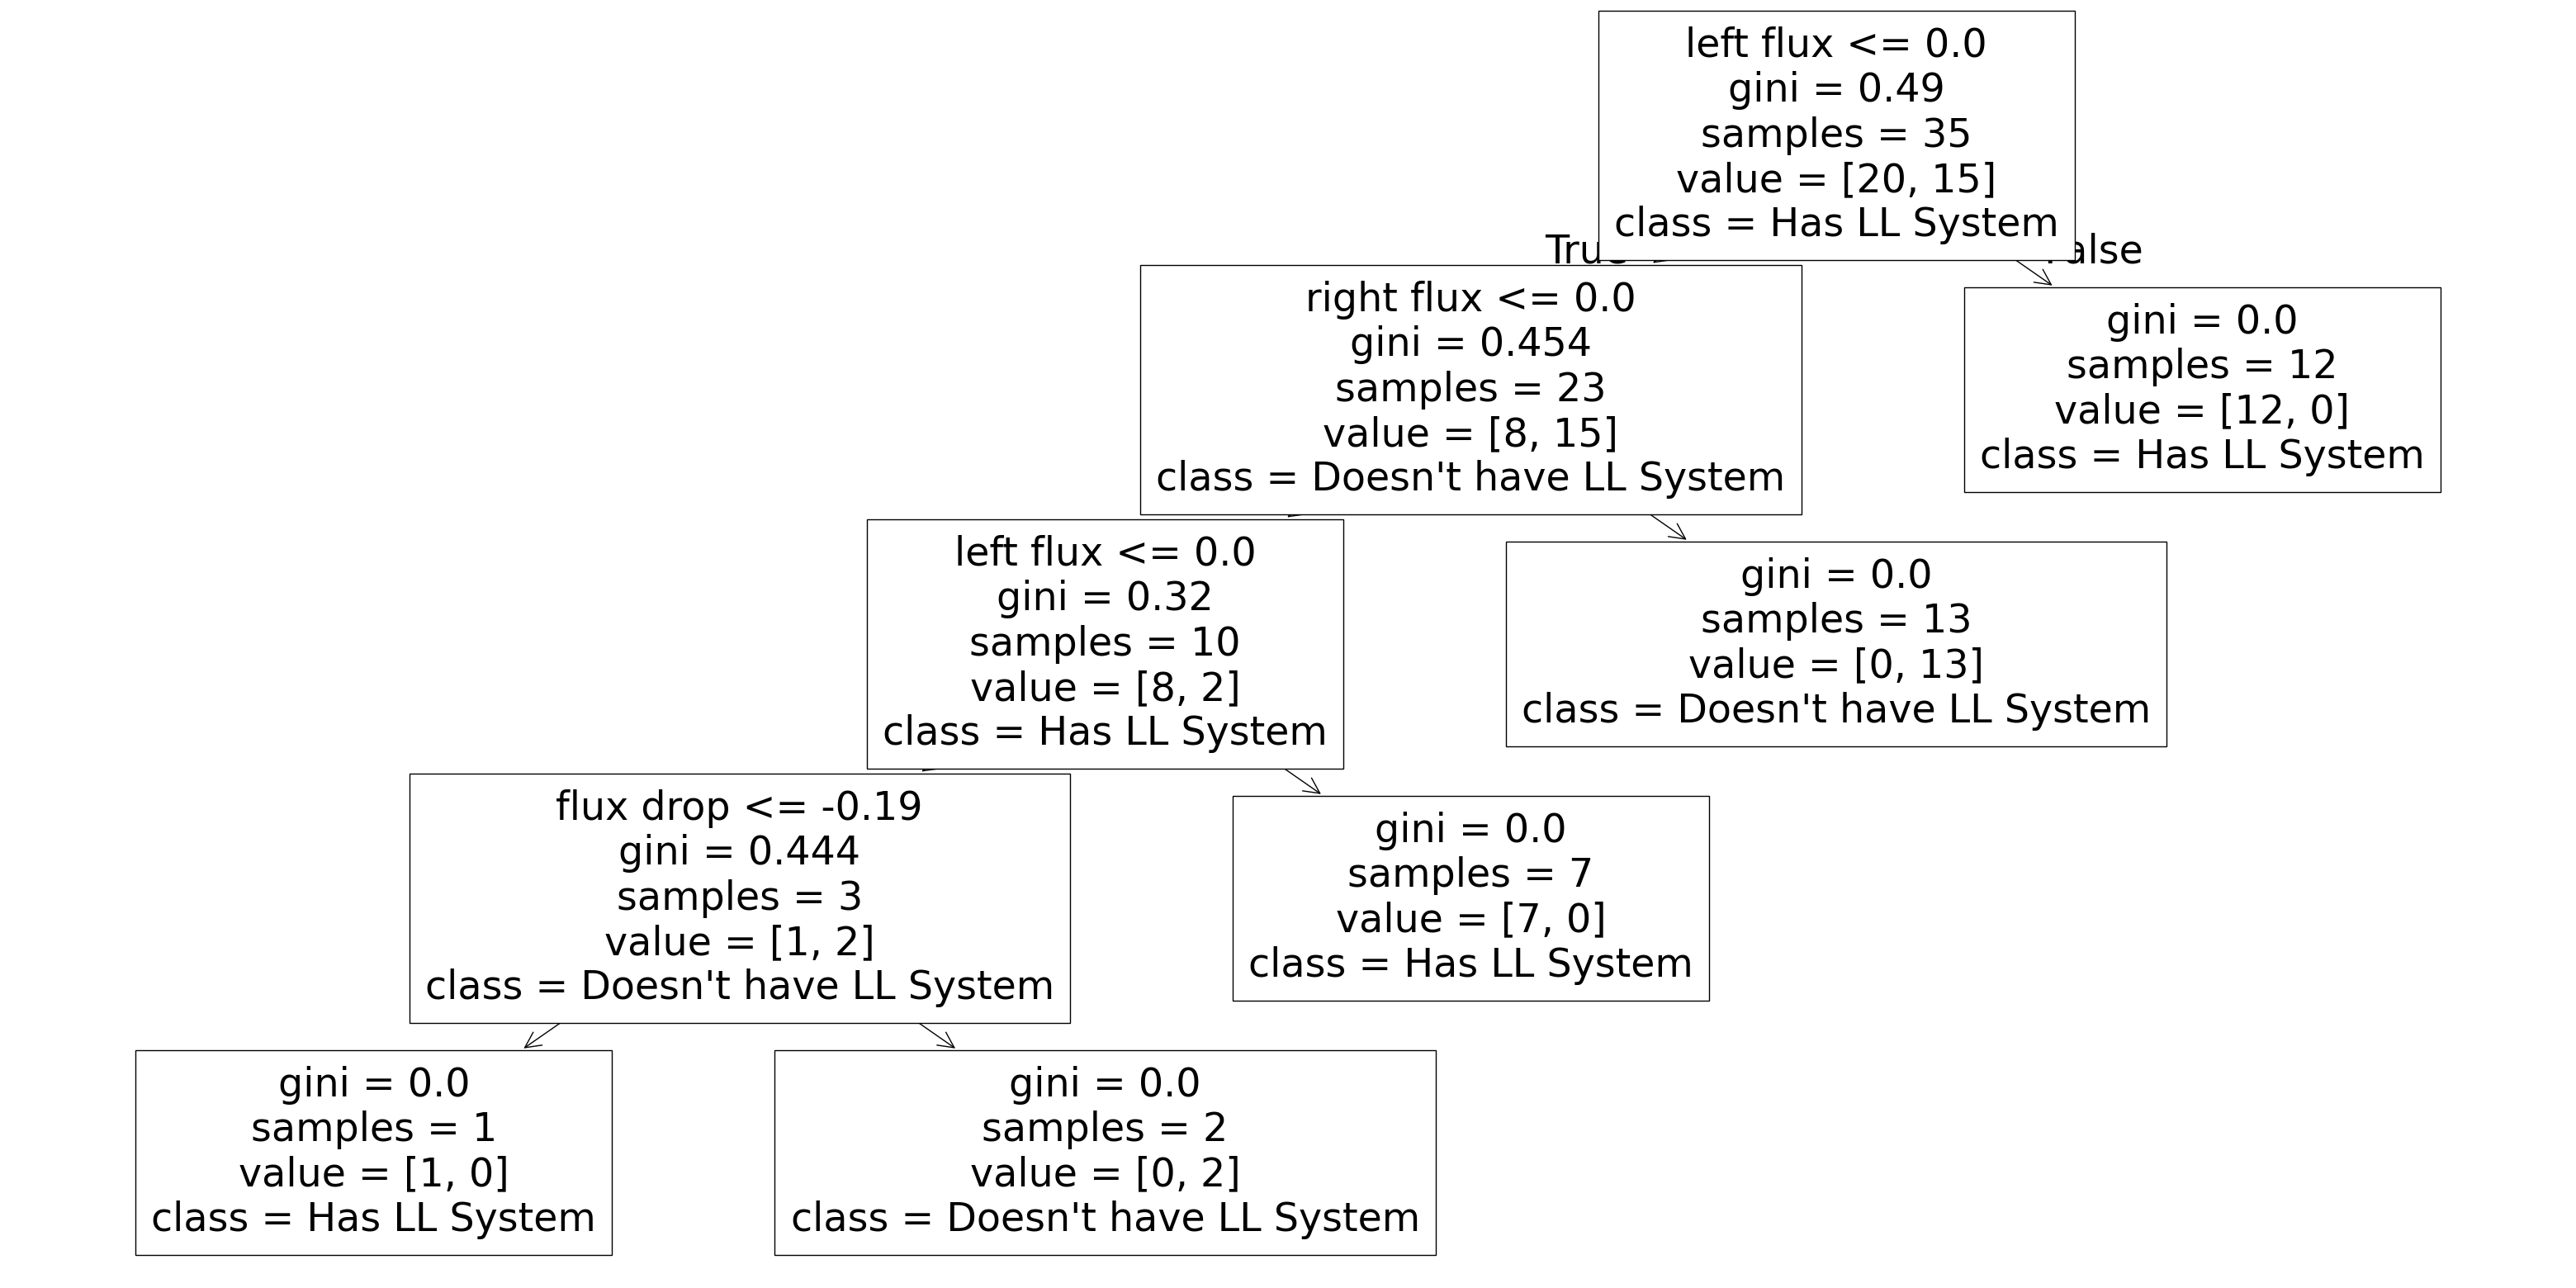

In [104]:
from sklearn import tree

#plotting the visualized decision tree model

plt.figure(figsize=(40,20))
_ = tree.plot_tree(model, feature_names = ['left flux', 'right flux', 'redshift', 'sigma', 'flux drop'], class_names = ['Has LL System',"Doesn't have LL System"])

In [105]:
#creating the model's predictions for the testing set and printing the model's predicted results and the actual test results

y_predict_test = model.predict(xtest)
y_predict_train = model.predict(xtrain)
print('actual test values:', ytest)
print('predicted test values:', y_predict_test)
print()
print('actual train values:', ytrain)
print('predicted train values:', y_predict_train)

actual test values:     ll system
36        0.0
37        0.0
38        1.0
39        1.0
40        1.0
41        1.0
42        1.0
43        1.0
44        0.0
45        1.0
46        0.0
47        1.0
48        0.0
49        1.0
50        0.0
51        1.0
52        1.0
53        1.0
54        0.0
predicted test values: [0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0.]

actual train values:     ll system
0         0.0
1         1.0
2         1.0
3         0.0
4         0.0
5         0.0
6         1.0
7         1.0
8         1.0
9         0.0
10        0.0
11        1.0
12        0.0
13        0.0
14        0.0
15        0.0
16        0.0
17        0.0
18        1.0
19        0.0
20        1.0
21        0.0
22        1.0
23        0.0
24        0.0
25        0.0
26        1.0
27        0.0
28        1.0
29        0.0
30        1.0
31        1.0
32        1.0
33        0.0
34        1.0
predicted train values: [0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1

In [106]:
# printing the accuracy score of the initial prediction
print('test accuracy:', metrics.accuracy_score(ytest, y_predict_test))
print('train accuracy:', metrics.accuracy_score(ytrain, y_predict_train))


test accuracy: 0.7368421052631579
train accuracy: 1.0


In [107]:
# creating the confusion matrix
conf_matrix = metrics.confusion_matrix(ytest, y_predict_test)


In [108]:
# function taken from the Chapter 3 notebook for plotting a confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.

    Inputs
    cm: confusion matrix (2D numpy array)
    classes: list of class labels
    normalize: whether to normalize the matrix
    title: title of the plot
    cmap: color map for the plot
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.figure(figsize=(7,6))
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center", verticalalignment="center",
                 color="green" if i == j else "red", fontsize = 30)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Confusion matrix, without normalization
[[7 0]
 [5 7]]


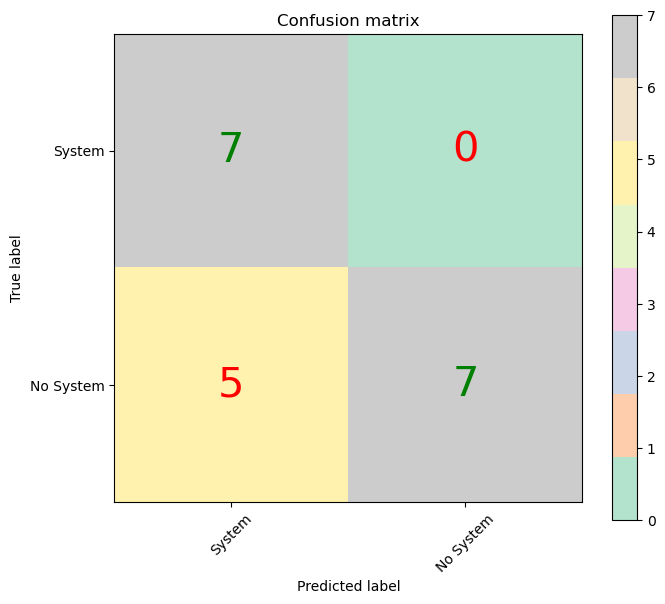

In [109]:
#plotting the confusion matrix from the initial results
plot_confusion_matrix(conf_matrix, ['System','No System'], cmap = plt.cm.Pastel2)


In [110]:
# calculating and printing the precision and recall scores

TP = 7 #predicted system and has system
FP = 5 #predicted system and doesn't have system
TN = 7 #predicted doesn't have system and doesn't have system
FN = 0 #predicted is doesn't have system and has system

# Precision - how many yes are true out of all the yes
precision_calculation = TP / (TP + FP)
print('My calculated precision:', precision_calculation)

# Recall - how many yes are true out of all the trues
recall_calculation = TP / (TP + FN)
print('My calculated recall:', recall_calculation)

My calculated precision: 0.5833333333333334
My calculated recall: 1.0


## Changing train/test set sizes and bounds for left/right flux calculations - final results

40
14


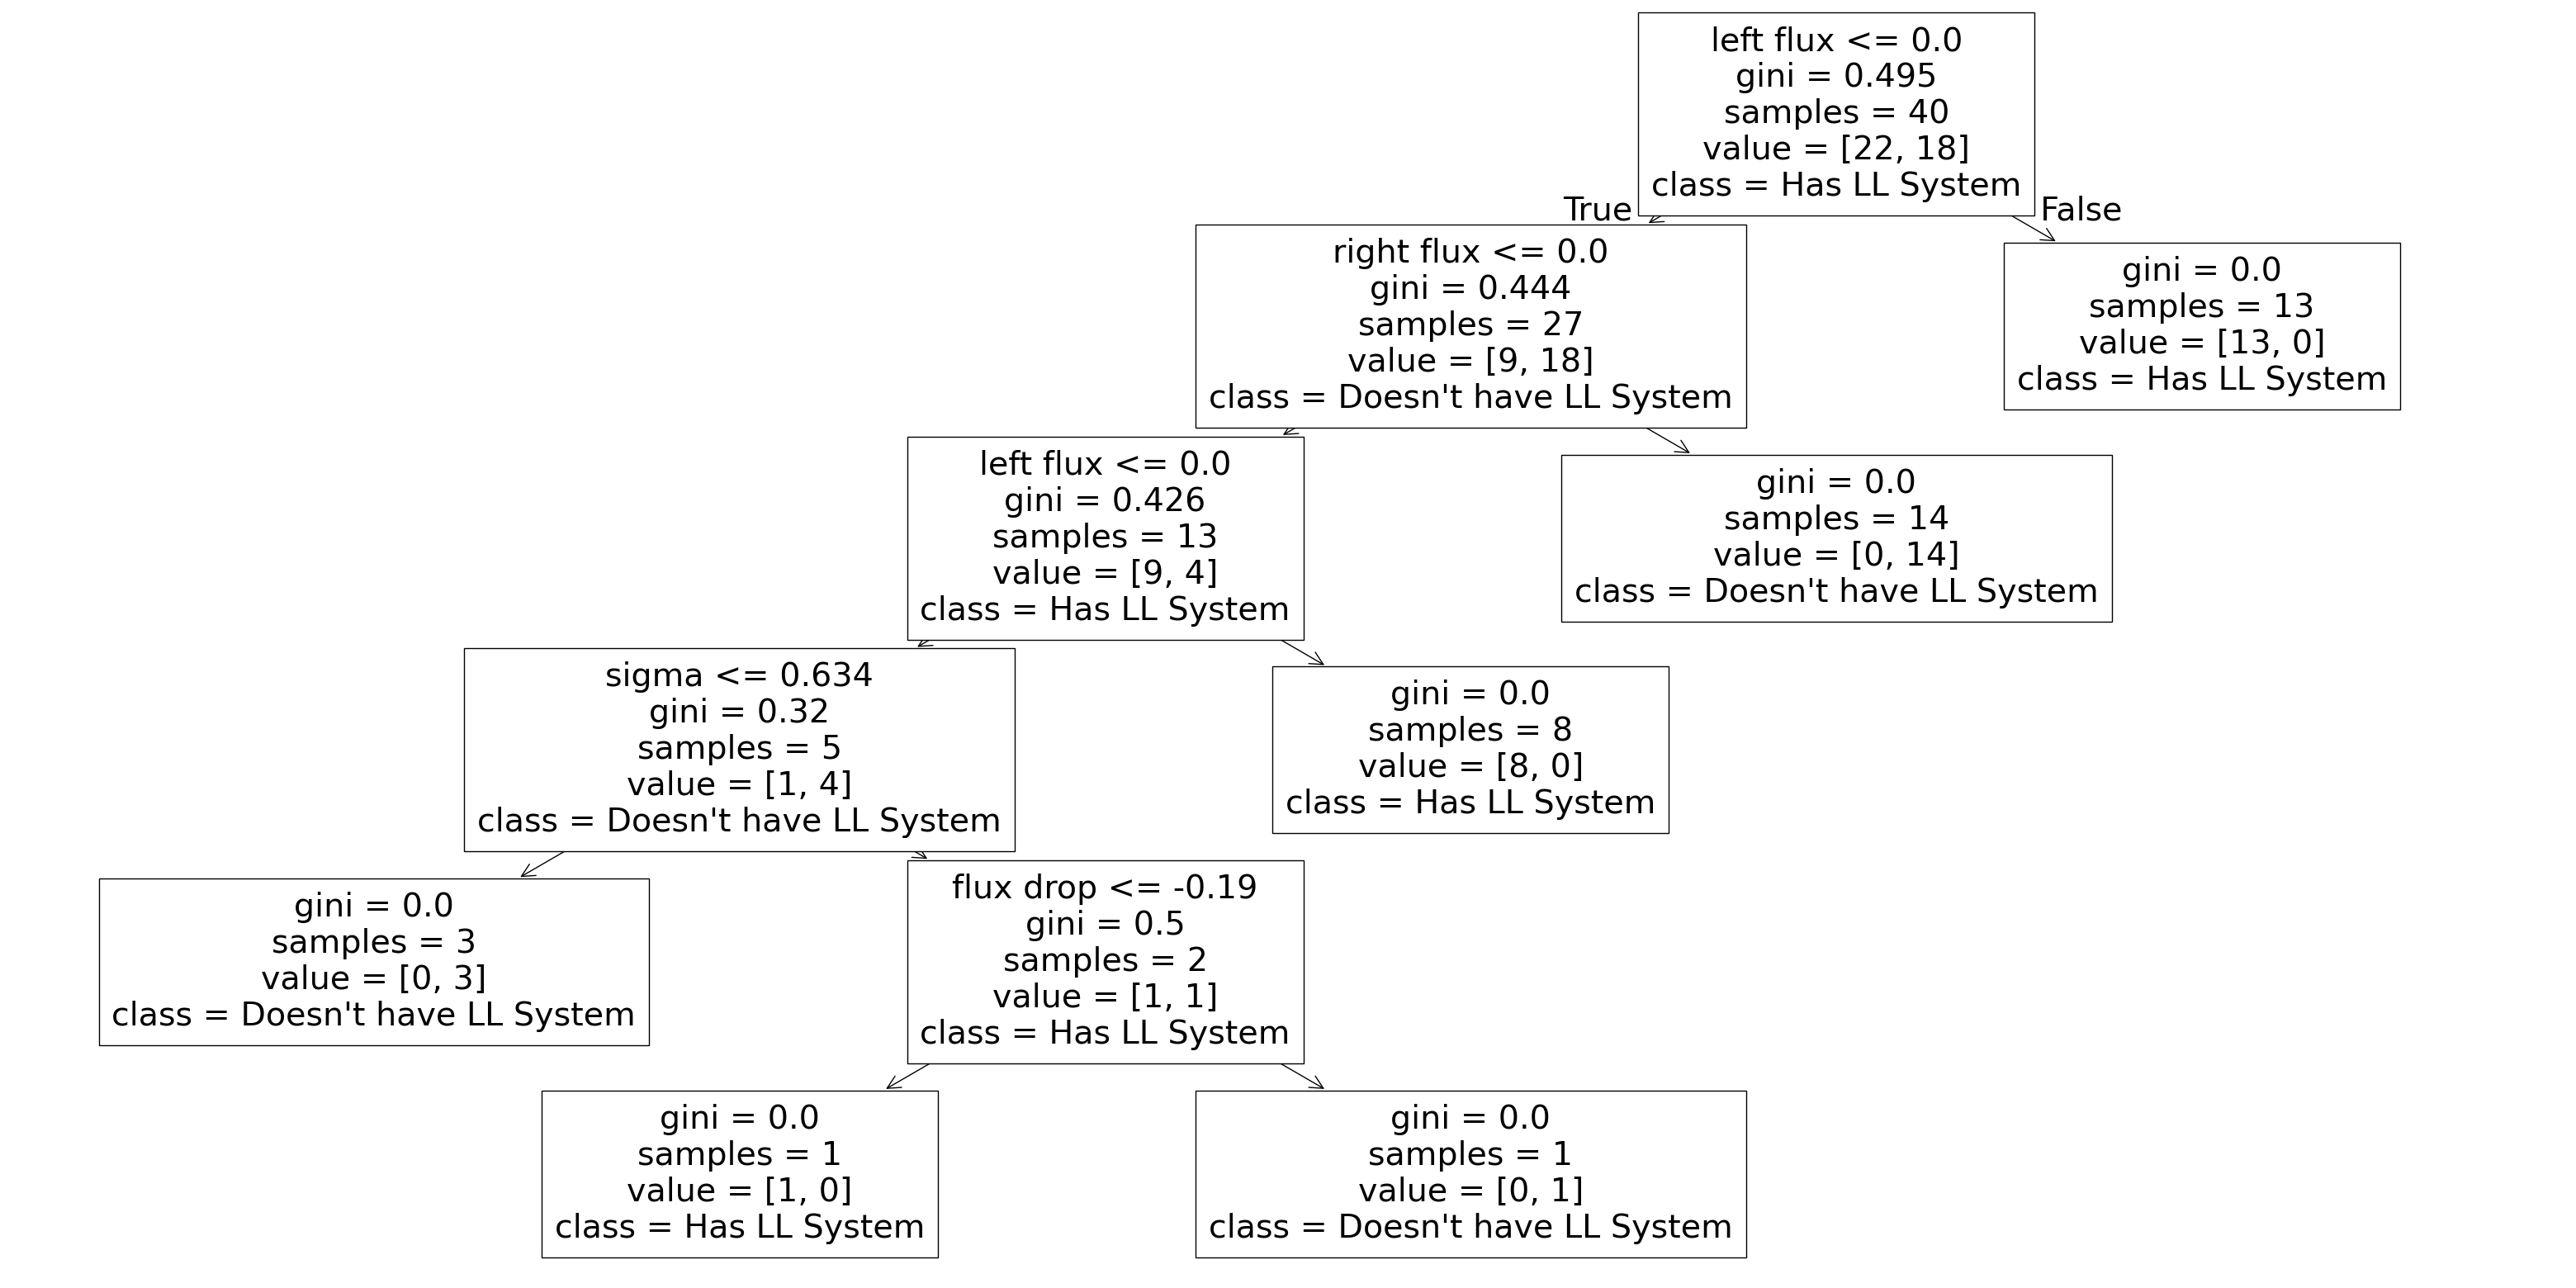

In [111]:
# Changing the training and testing split and assigning the features and targets
training_set2 =  data.iloc[:40,:]
testing_set2 = data.iloc[41:,:]
print(len(training_set2))
print(len(testing_set2))
      
xtrain2 = training_set2.drop(['ll system'], axis=1)
ytrain2 = training_set2.drop(['left flux', 'right flux', 'redshift', 'sigma', 'flux drop'], axis=1)
xtest2 = testing_set2.drop(['ll system'], axis=1)
ytest2 = testing_set2.drop(['left flux', 'right flux', 'redshift', 'sigma', 'flux drop'], axis=1)

#fitting the new model to the updated training set and plotting the visualized decision tree
model2 = DecisionTreeClassifier(random_state = 3)
model2.fit(xtrain2, ytrain2)
plt.figure(figsize=(40,20))
_ = tree.plot_tree(model2, feature_names = ['left flux', 'right flux', 'redshift', 'sigma', 'flux drop'], class_names = ['Has LL System',"Doesn't have LL System"])

In [112]:
#calculating the model's prediction and printing the accuracy of the prediction against the testing set
y_predict_test2 = model2.predict(xtest2)
y_predict_train2 = model2.predict(xtrain2)
print('test accuracy:', metrics.accuracy_score(ytest2, y_predict_test2))
print('train accuracy:', metrics.accuracy_score(ytrain2, y_predict_train2))

test accuracy: 0.7857142857142857
train accuracy: 1.0


Confusion matrix, without normalization
[[5 0]
 [3 6]]


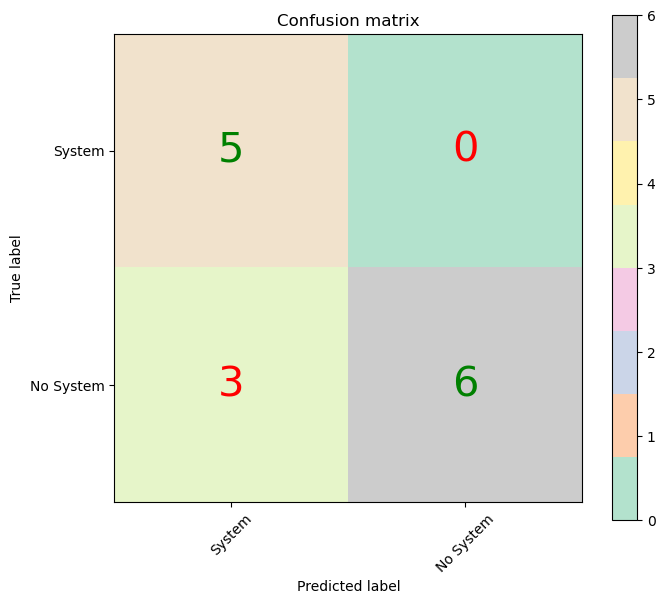

In [113]:
#creating and plotting the new model's confusion matrix
conf_matrix2 = metrics.confusion_matrix(ytest2, y_predict_test2)
plot_confusion_matrix(conf_matrix2, ['System','No System'], cmap = plt.cm.Pastel2)

In [114]:
# calculating and printing the precision and recall scores
TP2 = 5 #predicted system and has system
FP2 = 3 #predicted system and doesn't have system
TN2 = 6 #predicted doesn't have system and doesn't have system
FN2 = 0 #predicted is doesn't have system and has system

# Precision - how many yes are true out of all the yes
precision_calculation2 = TP2 / (TP2 + FP2)
print('My calculated precision:', precision_calculation2)

# Recall - how many yes are true out of all the trues
recall_calculation2 = TP2 / (TP2 + FN2)
print('My calculated recall:', recall_calculation2)

My calculated precision: 0.625
My calculated recall: 1.0


## kNN cross validation

In [115]:
#assigning the feature names and target name to a 'features' and 'target' variable, to be read into the KFold model
feature_columns = ['left flux', 'right flux', 'right flux', 'redshift', 'sigma', 'flux drop']
target_columns = ['ll system']

features = data[feature_columns]
target = data[target_columns]

# creating a model through three KFold methods
#   1)unshuffled
#   2)shuffled
#   3)stratified
cv1 = model_selection.KFold(n_splits = 5)
cv2 = model_selection.KFold(shuffle = True, n_splits = 5, random_state=5)
cv3 = model_selection.StratifiedKFold(shuffle = True, n_splits = 5, random_state=5)

#running cross validation on all three methods using accuracy as the scoring metric
scores1 = model_selection.cross_validate(tree.DecisionTreeClassifier(),  features, target, cv = cv1, scoring = 'accuracy')
scores2 = model_selection.cross_validate(tree.DecisionTreeClassifier(), features, target, cv = cv2, scoring = 'accuracy')
scores3 = model_selection.cross_validate(tree.DecisionTreeClassifier(), features, target, cv = cv3, scoring = 'accuracy')


In [116]:
#calculating and printing the mean and standard deviation of the accuary metric for all three methods of KFolds

# first method
cv1_mean = np.mean(scores1['test_score'])
cv1_stdev = np.std(scores1['test_score'])
print('cv1 mean:', cv1_mean)
print('cv1 standard deviation:', cv1_stdev)
print()

# second method
cv2_mean = np.mean(scores2['test_score'])
cv2_stdev = np.std(scores2['test_score'])
print('cv2 mean:', cv2_mean)
print('cv2 standard deviation:', cv2_stdev)
print()

# third method
cv3_mean = np.mean(scores3['test_score'])
cv3_stdev = np.std(scores3['test_score'])
print('cv3 mean:', cv3_mean)
print('cv3 standard deviation:', cv3_stdev)

cv1 mean: 0.890909090909091
cv1 standard deviation: 0.06803013430498073

cv2 mean: 0.8545454545454545
cv2 standard deviation: 0.0727272727272727

cv3 mean: 0.8727272727272727
cv3 standard deviation: 0.04453617714151229


In [117]:
#running cross validation on all three methods using recall as the scoring metric

scores1R = model_selection.cross_validate(tree.DecisionTreeClassifier(), features, target, cv = cv1, scoring = 'recall')
scores2R = model_selection.cross_validate(tree.DecisionTreeClassifier(), features, target, cv = cv2, scoring = 'recall')
scores3R = model_selection.cross_validate(tree.DecisionTreeClassifier(), features, target, cv = cv3, scoring = 'recall')


#calculating the mean and standard deviation of the accuary metric for all three methods of KFolds
# first method
cv1_meanR = np.mean(scores1R['test_score'])
cv1_stdevR = np.std(scores1R['test_score'])
print('cv1 mean:', cv1_meanR)
print('cv1 standard deviation:', cv1_stdevR)
print()

# second method
cv2_meanR = np.mean(scores2R['test_score'])
cv2_stdevR = np.std(scores2R['test_score'])
print('cv2 mean:', cv2_meanR)
print('cv2 standard deviation:', cv2_stdevR)
print()

# third method
cv3_meanR = np.mean(scores3R['test_score'])
cv3_stdevR = np.std(scores3R['test_score'])
print('cv3 mean:', cv3_meanR)
print('cv3 standard deviation:', cv3_stdevR)

cv1 mean: 0.8616666666666667
cv1 standard deviation: 0.14678025904202666

cv2 mean: 0.8933333333333333
cv2 standard deviation: 0.13727506854649335

cv3 mean: 0.86
cv3 standard deviation: 0.07118052168020872


In [118]:
#running cross validation on all three methods using precision as the scoring metric

scores1P = model_selection.cross_validate(tree.DecisionTreeClassifier(), features, target, cv = cv1, scoring = 'precision')
scores2P = model_selection.cross_validate(tree.DecisionTreeClassifier(), features, target, cv = cv2, scoring = 'precision')
scores3P = model_selection.cross_validate(tree.DecisionTreeClassifier(), features, target, cv = cv3, scoring = 'precision')


#calculating the mean and standard deviation of the accuary metric for all three methods of KFolds
# first method
cv1_meanP = np.mean(scores1P['test_score'])
cv1_stdevP = np.std(scores1P['test_score'])
print('cv1 mean:', cv1_meanP)
print('cv1 standard deviation:', cv1_stdevP)
print()

# second method
cv2_meanP = np.mean(scores2P['test_score'])
cv2_stdevP = np.std(scores2P['test_score'])
print('cv2 mean:', cv2_meanP)
print('cv2 standard deviation:', cv2_stdevP)
print()

# third method
cv3_meanP = np.mean(scores3P['test_score'])
cv3_stdevP = np.std(scores3P['test_score'])
print('cv3 mean:', cv3_meanP)
print('cv3 standard deviation:', cv3_stdevP)

cv1 mean: 0.8800000000000001
cv1 standard deviation: 0.16

cv2 mean: 0.8314285714285715
cv2 standard deviation: 0.10697235110170646

cv3 mean: 0.8428571428571429
cv3 standard deviation: 0.09110060223670947


In [119]:
from sklearn.model_selection import learning_curve

# function taken from the Chapter 3 notebook that plots the learning curve of the training and testing set 
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=5,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5), scoring = 'accuracy'):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), option
    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """

    plt.figure(figsize=(10,6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel(str(scoring))
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring = scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Test score from cross-validation")

    plt.legend(loc="best")
    return plt

/opt/anaconda3/envs/astro-416-final/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/astro-416-final/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/astro-416-final/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/astro-416-final/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  Fil

<module 'matplotlib.pyplot' from '/opt/anaconda3/envs/astro-416-final/lib/python3.11/site-packages/matplotlib/pyplot.py'>

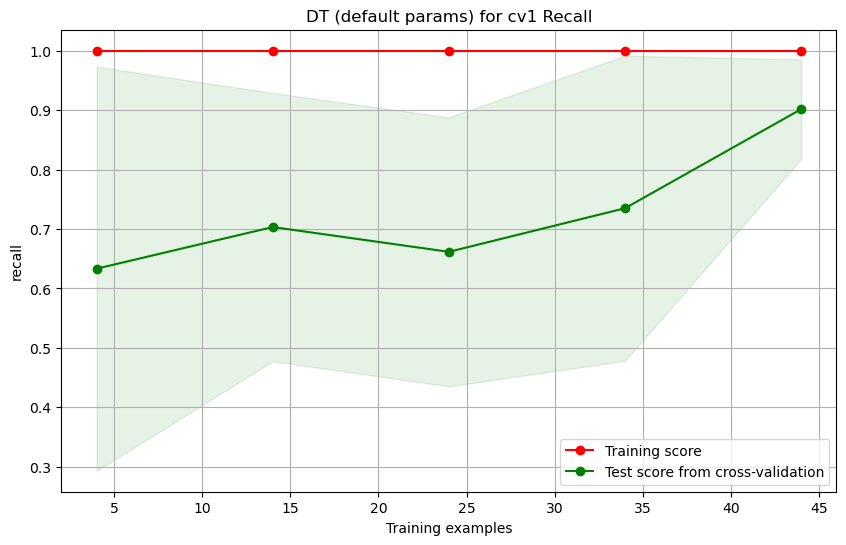

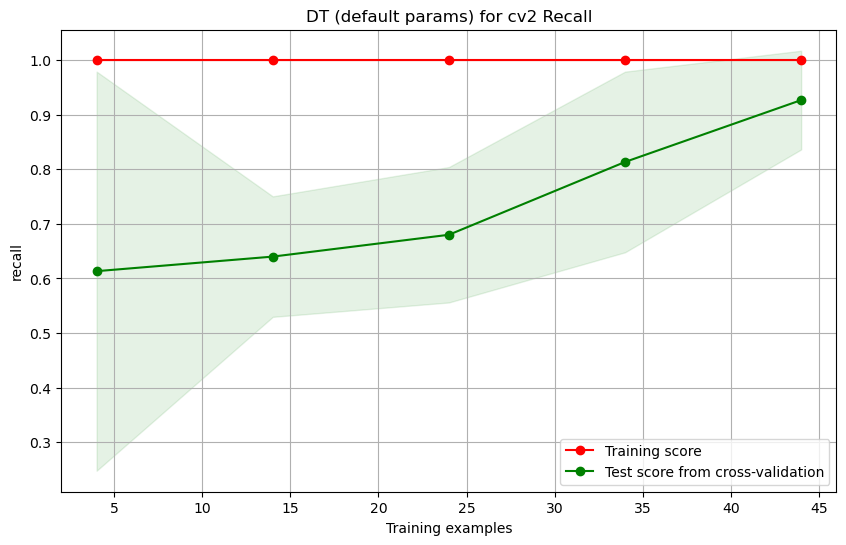

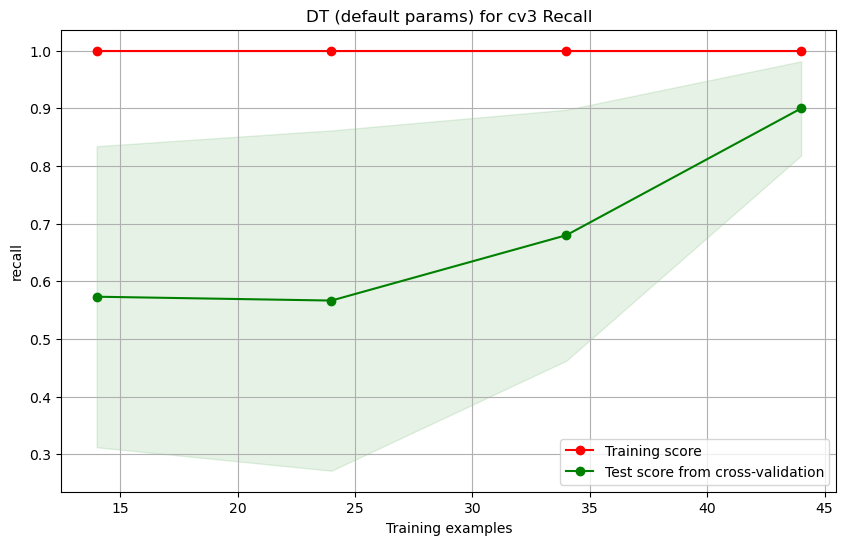

In [120]:
# plotting the learning curve for all three methods with recall as the scoring metric
plot_learning_curve(model2, 'DT (default params) for cv1 Recall', features, target,  cv = cv1, scoring = 'recall')
plot_learning_curve(model2, 'DT (default params) for cv2 Recall', features, target,  cv = cv2, scoring = 'recall')
plot_learning_curve(model2, 'DT (default params) for cv3 Recall', features, target,  cv = cv3, scoring = 'recall')


/opt/anaconda3/envs/astro-416-final/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/astro-416-final/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/astro-416-final/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/astro-416-final/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._sc

<module 'matplotlib.pyplot' from '/opt/anaconda3/envs/astro-416-final/lib/python3.11/site-packages/matplotlib/pyplot.py'>

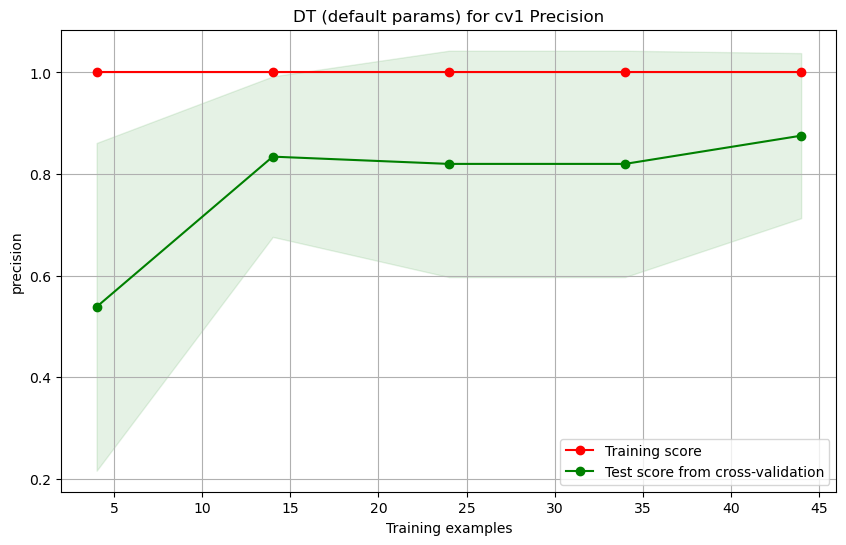

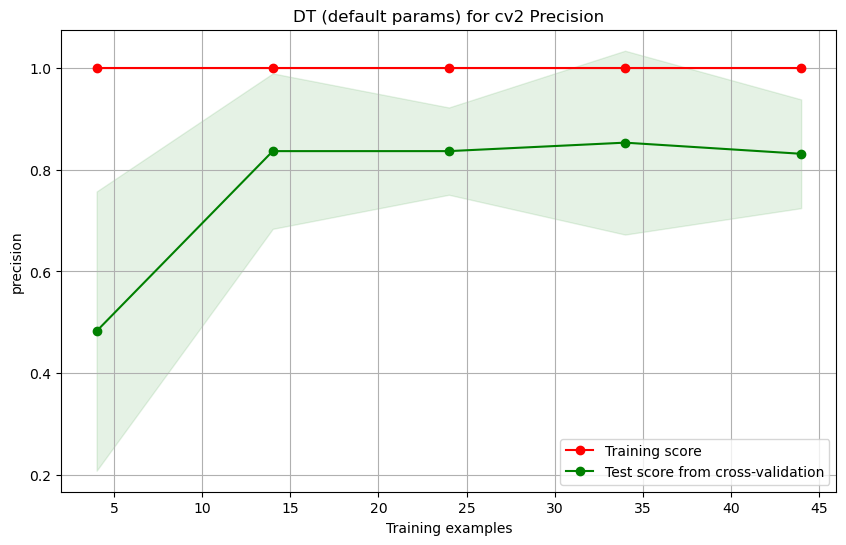

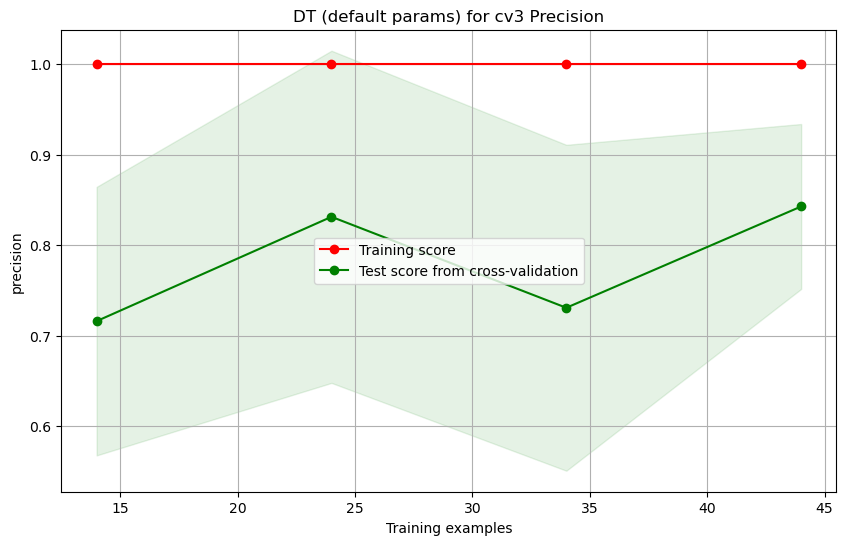

In [121]:
# plotting the learning curve for all three methods with precision as the scoring metric
plot_learning_curve(model2, 'DT (default params) for cv1 Precision', features, target,  cv = cv1, scoring = 'precision')
plot_learning_curve(model2, 'DT (default params) for cv2 Precision', features, target,  cv = cv2, scoring = 'precision')
plot_learning_curve(model2, 'DT (default params) for cv3 Precision', features, target,  cv = cv3, scoring = 'precision')
